# Adding Noise

In order to generate realistic data, we need to add noise to the CSDs after they
have been generated.

First, we'll generate a sample CSD to add noise to.

In [1]:
from qdflow import generate
import tutorial_helper
import numpy as np
import matplotlib.pyplot as plt
from qdflow.physics import noise

In [2]:
# Generate a sample CSD to add noise to, this may take ~ 20 seconds
phys = generate.default_physics(n_dots=2)
V_x = np.linspace(3., 12., 80)
V_y = np.linspace(3., 12., 80)
csd = generate.calc_2d_csd(phys, V_x, V_y)

Now we want to randomize the strengths of different types of noise to add.
This is done using the `NoiseRandomization` class.

In [3]:
# Create a randomization object with default distributions for each parameter
noise_rand = noise.NoiseRandomization.default()

# Print out some of the default distributions
print("White Noise Magnitude: %s" % str(noise_rand.white_noise_magnitude))
print("Amount of Latching: %s" % str(noise_rand.latching_pixels))

White Noise Magnitude: distribution.Uniform(0.08, 0.12)
Amount of Latching: (distribution.Normal(1, 0.3)).abs()


We can then sample each of the distributions and obtain a `NoiseParameters` instance, which defines the magnitude and other parameters for each type of noise.
In general, you will want a seperate `NoiseParameters` instance for each CSD.

In [4]:
noise.set_rng_seed(9)

# Obtain a set of noise parameters by drawing from the noise_rand distributions.
noise_params = noise.random_noise_params(noise_rand)

# Print out some of the noise parameter values
print("White Noise Magnitude: %s" % str(noise_params.white_noise_magnitude))
print("Amount of Latching: %s" % str(noise_params.latching_pixels))

White Noise Magnitude: 0.11480996815880339
Amount of Latching: 1.1291457236662927


Then noise can be added to a CSD using `NoiseGenerator.calc_noisy_map()`.

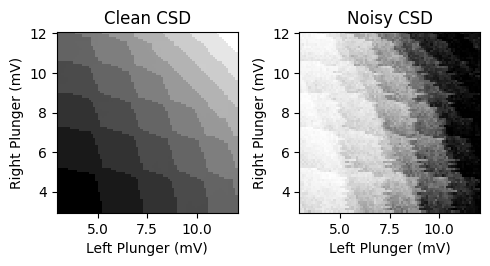

In [5]:
clean_data = csd.sensor[:,:,0]

noise.set_rng_seed(10)

# Add noise to the CSD
noisy_data = noise.NoiseGenerator(noise_params).calc_noisy_map(clean_data)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(5,2.7))
tutorial_helper.plot_csd_data(fig, ax[0], clean_data, x_y_vals=(csd.V_x, csd.V_y))
ax[0].set_title("Clean CSD")
tutorial_helper.plot_csd_data(fig, ax[1], noisy_data, x_y_vals=(csd.V_x, csd.V_y))
ax[1].set_title("Noisy CSD")
fig.tight_layout()

You can turn specific noise types on or off when adding noise.

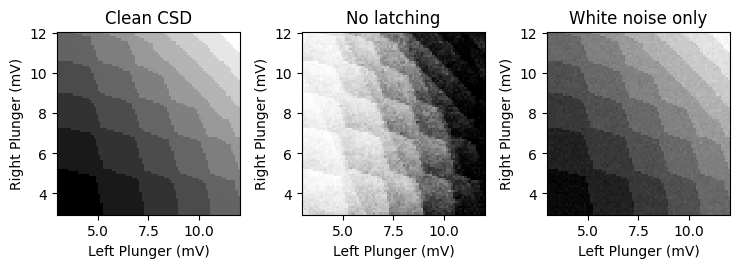

In [6]:
noise.set_rng_seed(11)

# Turn off latching
no_latching = noise.NoiseGenerator(noise_params).calc_noisy_map(
        clean_data, latching=False)

# Use white noise only
white_noise_only = noise.NoiseGenerator(noise_params).calc_noisy_map(
        clean_data, noise_default=False, white_noise=True)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(7.5,2.7))
tutorial_helper.plot_csd_data(fig, ax[0], clean_data, x_y_vals=(csd.V_x, csd.V_y))
ax[0].set_title("Clean CSD")
tutorial_helper.plot_csd_data(fig, ax[1], no_latching, x_y_vals=(csd.V_x, csd.V_y))
ax[1].set_title("No latching")
tutorial_helper.plot_csd_data(fig, ax[2], white_noise_only, x_y_vals=(csd.V_x, csd.V_y))
ax[2].set_title("White noise only")
fig.tight_layout()

Latching is implemented in two different ways:

* The simple latching method is performed by shifting each row
by a random number of pixels.

* The excited-state latching method involves replacing pixels with excited state
data for several pixels after each transition.

The excited-state latching method is more realistic, but requires additional data
about the excited states and transitions.

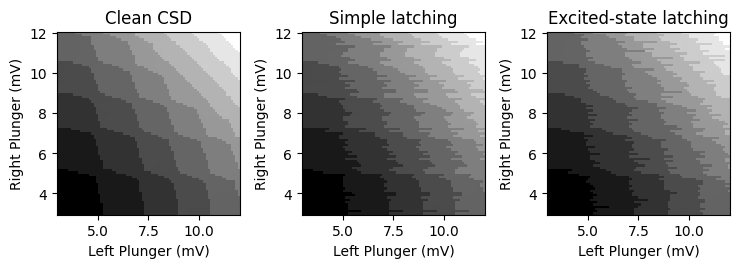

In [7]:
noise.set_rng_seed(12)

# Increase the latching amount for demonstration purposes
noise_params_2 = noise_params.copy()
noise_params_2.latching_pixels = 1.7

# Simple latching is used if no additional data is provided
simple_latching = noise.NoiseGenerator(noise_params_2).calc_noisy_map(
        clean_data, noise_default=False, latching=True)

# Excited-state latching requires excited state data, charge states,
# and whether dots are combined
excited_data = csd.excited_sensor[:,:,0]
dot_charges = csd.dot_charges
are_dots_combined = csd.are_dots_combined

excited_latching = noise.NoiseGenerator(noise_params_2).calc_noisy_map(
        clean_data, latching_data=(excited_data, dot_charges, are_dots_combined),
        noise_default=False, latching=True)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(7.5,2.7))
tutorial_helper.plot_csd_data(fig, ax[0], clean_data, x_y_vals=(csd.V_x, csd.V_y))
ax[0].set_title("Clean CSD")
tutorial_helper.plot_csd_data(fig, ax[1], simple_latching, x_y_vals=(csd.V_x, csd.V_y))
ax[1].set_title("Simple latching")
tutorial_helper.plot_csd_data(fig, ax[2], excited_latching, x_y_vals=(csd.V_x, csd.V_y))
ax[2].set_title("Excited-state latching")
fig.tight_layout()

Note for simple latching, the latching pattern repeats for each transition,
whereas for excited-state latching, the latching pattern is unique for each transition.